In [1]:
%load_ext autoreload
%autoreload 2
#from coach import train_nn, compute_elo
from test_train import train
from configuration import resnet20, simple
from utils.utils import HDFStoreDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime
import torch
from torchsummary import summary

In [2]:
class TensorBoardMock:
    def __init__(self):
        self.df = pd.DataFrame(columns=["batch_i", "lr", "v/train", "v/eval", "pi/train", "pi/eval", "total/train", "total/eval"])
        self.batch_i = 0
        self.row = {}
        
    def add_scalar(self, name, value, batch_i):
        if batch_i != self.batch_i:
            self.df = self.df.append(self.row, ignore_index=True)
            self.row = {}
            self.row["batch_i"] = batch_i
        self.row[name] = value
    
    def add_scalars(self, unused, key_values, batch_i):
        if batch_i != self.batch_i:
            self.df = self.df.append(self.row, ignore_index=True)
            self.row = {}
            self.row["batch_i"] = batch_i
        self.row.update(key_values)

In [3]:
def save_exp(folder, suffix, log, params):
    fn = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")+ "_" + suffix
    with open(folder+"/"+fn+"_params.json", "w") as f:
        json.dump(params, f, default=lambda o: o.__name__ if isinstance(o, type) else '<not serializable>', indent=2)
    log.to_csv(folder+"/"+fn+"_log.csv")
    log.plot(figsize=(12,12), grid=True, ylim=(0,3))
    plt.savefig(folder+"/"+fn+".png")

{'resnet': {'pad_layer0': True, 'in_channels': 3, 'nb_channels': 64, 'inner_channels': None, 'kernel_size': 3, 'nb_blocks': 20, 'n_groups': 1}, 'policy_head': {'in_channels': 64, 'inner_channels': 2, 'fc_in': 32, 'nb_actions': 32}, 'value_head': {'in_channels': 64, 'inner_channels': 1, 'fc_in': 16, 'fc_inner': 8}}
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1              [-1, 3, 4, 4]               6
            Conv2d-2             [-1, 64, 4, 4]           1,792
       BatchNorm2d-3             [-1, 64, 4, 4]             128
            Conv2d-4             [-1, 64, 4, 4]          36,928
       BatchNorm2d-5             [-1, 64, 4, 4]             128
            Conv2d-6             [-1, 64, 4, 4]          36,928
       BatchNorm2d-7             [-1, 64, 4, 4]             128
          ResBlock-8             [-1, 64, 4, 4]               0
            Conv2d-9             [-1, 64, 4

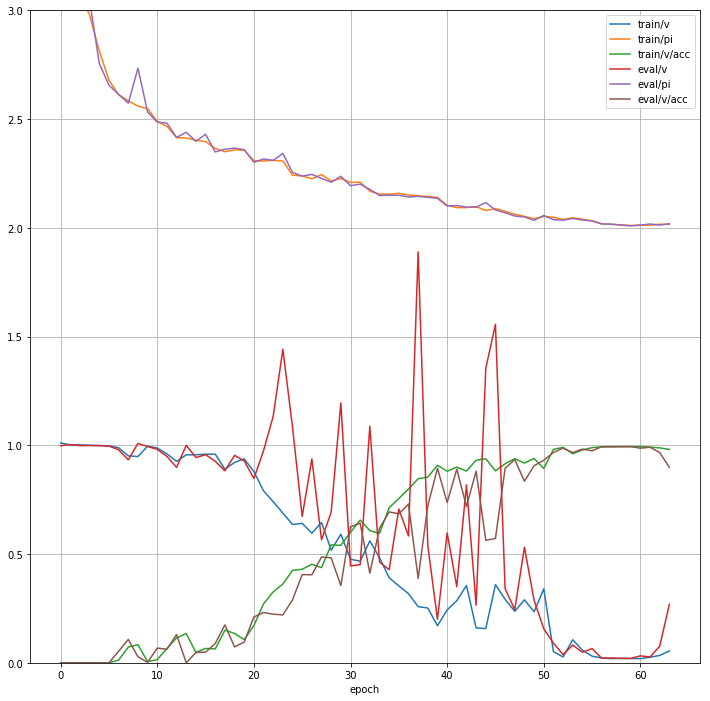

In [7]:
params = resnet20 #simple

params.game.init()
params.rewrite_str("_exp_", "resnet20_1229")
params.nn.train_params.lr = 0.1
params.nn.train_params.lr_scheduler = None
params.nn.train_params.pos_average = False
params.nn.train_params.train_batch_size = 4096
#params.nn.train_params.symmetries = lambda boards, p, z: ([boards], [p], [z])

params.nb_epochs = 4
params.where = "generation>={} and generation<={}" #"generation>=10 and generation<=19"
params.avg = params.nn.train_params.pos_average

params.nn.model_parameters.resnet.pad_layer0 = True

nb_features = 16 if params.nn.model_parameters.resnet.pad_layer0 else 4
model_p = params.nn.model_parameters
model_p.resnet.nb_blocks = 20
model_p.resnet.n_groups = 1
model_p.resnet.inner_channels = None
model_p.resnet.nb_channels = 64
model_p.value_head.in_channels = 64
model_p.policy_head.in_channels = 64
model_p.policy_head.inner_channels = 2
model_p.policy_head.fc_in = 2*nb_features

model_p.value_head.inner_channels = 1
model_p.value_head.fc_in = model_p.value_head.inner_channels*nb_features
model_p.value_head.fc_inner = 8
print(model_p)

def _fake_z(boards, z):
    minus_ones = boards[:, :-1, :, :].sum((1,2,3)) % 2 == 0
    #minus_ones = boards[:, :-1, :, :].sum((1,2,3)) > 8
    z = np.ones_like(z)
    z[minus_ones] = -1.0
    print(len(boards), minus_ones.sum())
    return z
fake_z =  _fake_z


model = params.nn.model_class(params)
summary(model, input_size=(3, 4, 4), device="cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=params.nn.train_params.lr, **(params.nn.train_params.optimizer_params))

model = model.to(params.nn.pytorch_device)
for state in optimizer.state.values():
    for k, v in state.items():
        print(type(v))
        if isinstance(v, torch.Tensor):
            state[k] = v.to(to_device)
            
log = None
for gen in range(0, 16):
    where = f"generation>={max(0, min((gen-4)//2, 20))} and generation<={gen}"
    print(where)
    
    train_ds = HDFStoreDataset(params.hdf_file, "data", train=True, features_shape=params.game.clazz.FEATURES_SHAPE, 
                               where=where, pos_average=params.avg, fake_z=fake_z)
    mean, std = train_ds.normalize()
    #mean, std = train_ds.get_normalization()
    #model.set_inputs_normalization(mean, std, params.nn.pytorch_device)

    val_ds = HDFStoreDataset(params.hdf_file, "data", train=False, features_shape=params.game.clazz.FEATURES_SHAPE, 
                             where=where, pos_average=params.avg, fake_z=fake_z)
    val_ds.normalize(mean, std)

    fn = f"same_params"
    l = train(model, optimizer, params, train_ds, val_ds, params.nb_epochs, gen*params.nb_epochs, 1)
    if log is None:
        log = l
    else:
        log = log.append(l)
        
save_exp("test_train_1229", fn, log, params)

In [5]:
next(list(list(model.modules())[1].modules())[0].parameters())

Parameter containing:
tensor([1.6626, 1.6420, 0.4878], device='cuda:0', requires_grad=True)

In [6]:
from test.nn_unittests import load_boards_samples
from nn import NeuralNetWrapper

df = load_boards_samples()

wrapper = NeuralNetWrapper(model, params)

for i, sample in df.iterrows():
    print(i)
    print(sample.game)
    print("Next moves:", sample.next_moves)
    print("Z:", sample.z)
    p, v = wrapper.predict_sync(np.expand_dims(sample.game.get_features(), 0))
    p = p[0]
    p *= sample.game.get_valid_moves()
    p /= p.sum()
    for i, p in enumerate(p.round(2)):
        if p>0.0:
            print(f"{i}->{p:.2f}", end="; ")
    print("")
    print("v:", v[0])

-1
------------------------------
Just played = 0
To play = 1
Boxes to close = [1.5, 1.5]
Result = None
+---+---+---+
|   |   |   |   
+---+---+---+
|   |   |   |   
+---+---+---+
|               
+---+---+---+

Next moves: [25]
Z: 1
25->0.46; 26->0.13; 27->0.41; 
v: [-0.9397975]
0
------------------------------
Just played = 0
To play = 1
Boxes to close = [4.5, 4.5]
Result = None
+---+   +   +
|   |   |       
+   +   +---+
|   |           
+   +---+---+
|               
+---+---+---+

Next moves: [4]
Z: 1
1->0.06; 2->0.04; 4->0.08; 5->0.04; 8->0.08; 19->0.06; 22->0.09; 23->0.20; 25->0.06; 26->0.08; 27->0.20; 
v: [-0.65196323]
1
------------------------------
Just played = 1
To play = 1
Boxes to close = [4.5, 3.5]
Result = None
+---+   +   +
|   |   |       
+---+   +---+
|   |           
+   +---+---+
|               
+---+---+---+

Next moves: [8]
Z: 1
1->0.07; 2->0.05; 5->0.04; 8->0.09; 19->0.07; 22->0.08; 23->0.23; 25->0.06; 26->0.09; 27->0.22; 
v: [-0.9658736]
2
-----------------

In [ ]:
params = resnet20 #simple

params.game.init()
params.rewrite_str("_exp_", "test_train")
params.nn.train_params.lr = 0.001
params.nn.train_params.lr_scheduler = None
params.nn.train_params.pos_average = False
params.nn.train_params.train_batch_size = 4096
params.nn.train_params.symmetries = lambda boards, p, z: ([boards], [p], [z])

params.nb_epochs = 100
params.where = "generation==10" #"generation>5 and generation<=7"
params.avg = False

params.nn.model_parameters.pad_layer0 = False

for nblocks in [5, 10, 15, 20]:
    for block_channels in [4, 16, 64, 128, 256]:
        for v_channels in [1, 2, 4, 16]:
            if nblocks==5 and block_channels==4 and v_channels<4:
                continue
            v_inner = v_channels*8
            try:
                model_p = params.nn.model_parameters
                model_p.resnet.nb_blocks = nblocks
                model_p.resnet.nb_channels = block_channels
                model_p.value_head.in_channels = block_channels
                model_p.policy_head.in_channels = block_channels

                model_p.value_head.inner_channels = v_channels
                model_p.value_head.fc_in = v_channels*16
                model_p.value_head.fc_inner = v_inner

                print(model_p)
                train_ds = HDFStoreDataset(params.hdf_file, "data", train=True, features_shape=params.game.clazz.FEATURES_SHAPE, where=params.where, pos_average=params.avg)
                val_ds = HDFStoreDataset(params.hdf_file, "data", train=False, features_shape=params.game.clazz.FEATURES_SHAPE, where=params.where, pos_average=params.avg)
                model = params.nn.model_class(params)

                fn = f"{nblocks}_{block_channels}_{v_channels}_{v_inner}"
                log = train(model, params, train_ds, val_ds, params.nb_epochs)
                save_exp("test_train", fn, log, params)
            except Exception as e:
                print(e)
                print("Failed!", fn)

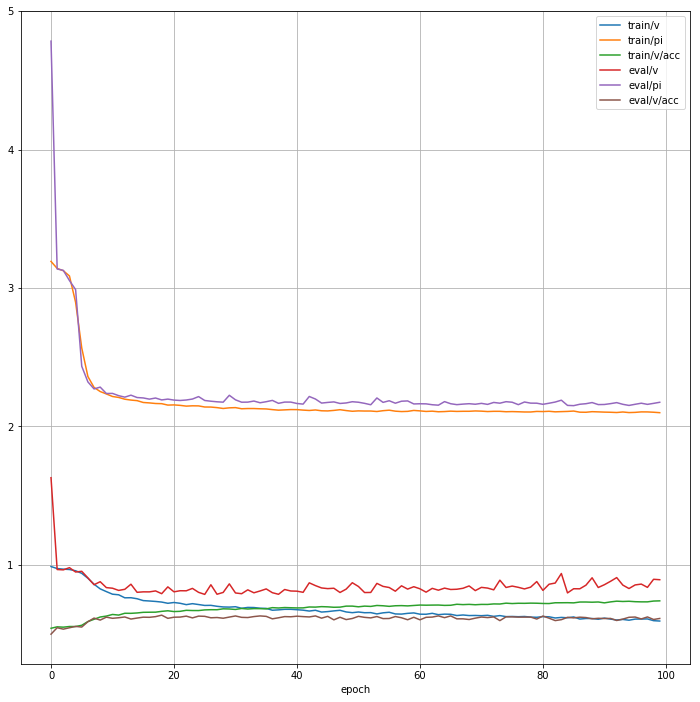

In [8]:
log.plot(figsize=(12,12), grid=True)
log.to_csv("test_train/resnet20_100epochs_lr0.01_batch2048_gen5.csv")

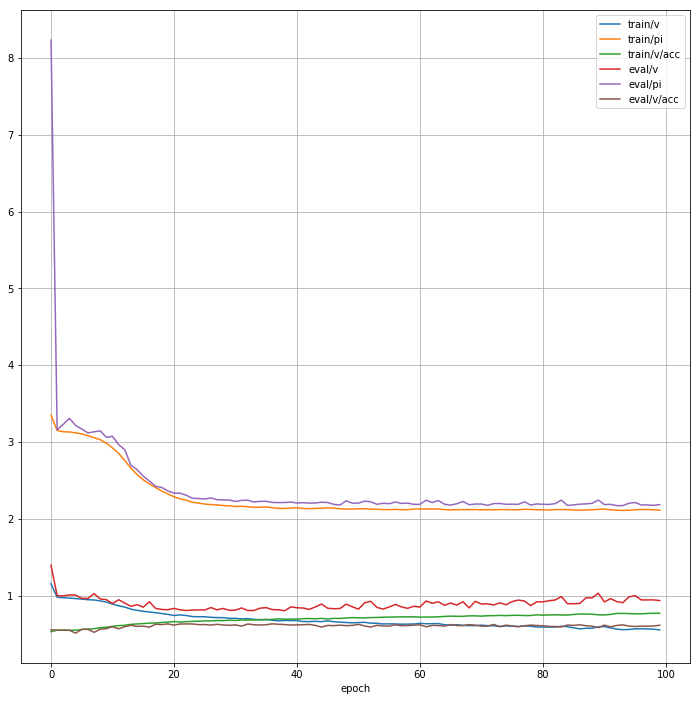

In [5]:
log.plot(figsize=(12,12), grid=True)
log.to_csv("test_train/simple_100epochs_lr0.01_batch2048_gen5.csv")

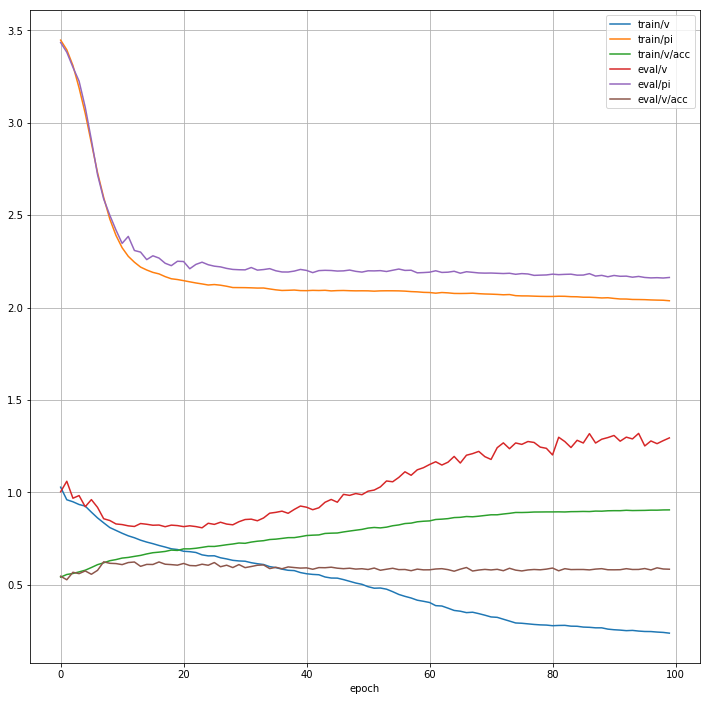

In [8]:
log.plot(figsize=(12,12), grid=True)
log.to_csv("test_train/simple_100epochs_lr0.001_batch2048_gen5.csv")

In [ ]:
log.plot(figsize=(12,12), grid=True)
plt.
log.to_csv("test_train/simple_100epochs_lr0.001_batch512_gen5.csv")

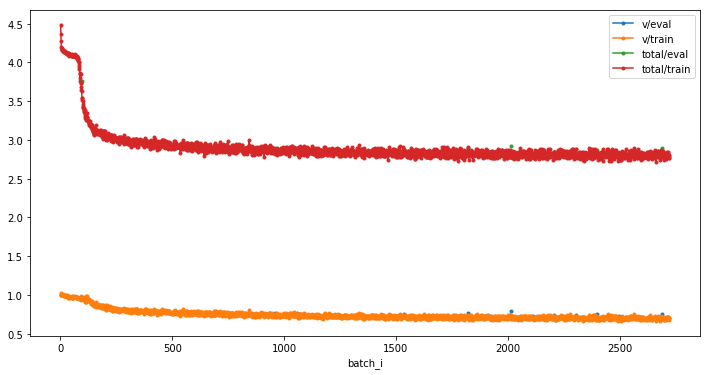

In [42]:
writer.df.plot(x="batch_i", y=["v/eval", "v/train", "total/eval", "total/train"], marker=".", figsize=(12,6))

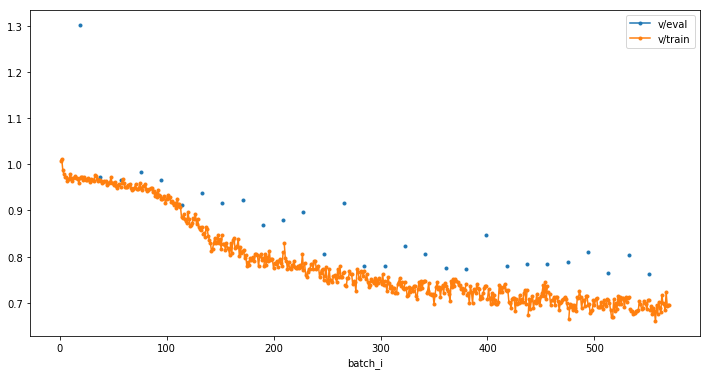

In [6]:
writer.df.plot(x="batch_i", y=["v/eval", "v/train"], marker=".", figsize=(12,6))

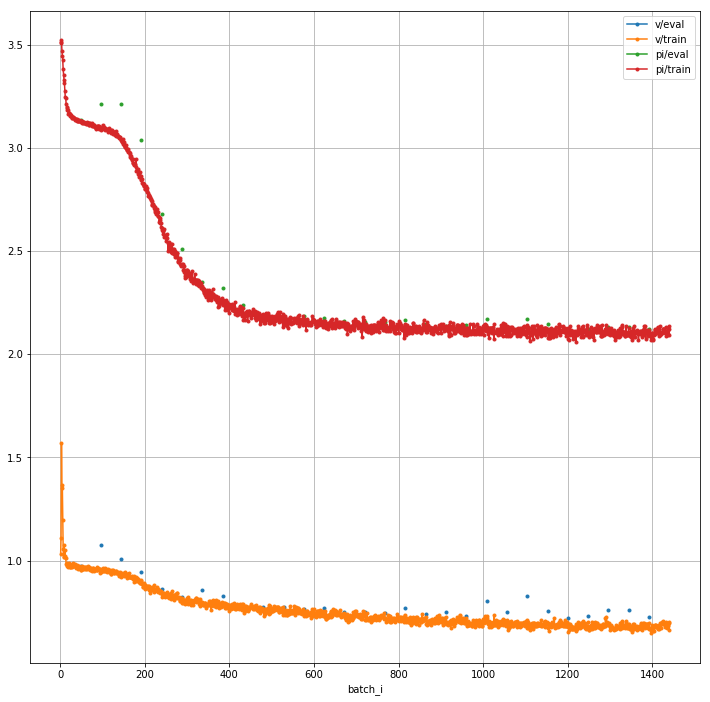

In [58]:
writer.df.plot(x="batch_i", y=["v/eval", "v/train", "pi/eval", "pi/train"], marker=".", grid=True, figsize=(12,12))

In [8]:
compute_elo(simple33.elo, (simple33, 10, 1200), (simple33, 4, 1200))

**********************************************************************
Computation of Elo ratings
Player0: model=SimpleNN, generation=10, elo=1200
Player1: model=SimpleNN, generation=4, elo=1200
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen10.pt
Model loaded from: data/simple2710/model_gen4.pt
Worker w17357 uses device cuda:0
Model loaded from: data/simple2710/model_gen4.pt
Worker w17359 uses device cuda:0
Model loaded from: data/simple2710/model_gen4.pt
Worker w17354 uses device cuda:1
Model loaded from: data/simple2710/model_gen4.pt
Model load

In [27]:
#######################################################################################
def debug_layers_dims(model, input_shape, headers=True):
    """Debug problems with layers dimensions.
    Args:
    model: the model to debug
    input_shape: pass train_input.shape"""
    from torch.autograd import Variable
    if input_shape:
        if headers:
            print("******************** Debugging layers sizes: ********************")
        print("input_shape= (_,{})".format(",".join(map(str,input_shape[1:]))))
        out = Variable(torch.rand(2, *input_shape[1:]))    
        for m in list(model.modules()):
            print(list(m.modules()))
            if type(m)==torch.nn.Sequential:
                print("**************************************")
                out = debug_layers_dims(m, out.shape, False)
            elif  isinstance(m, torch.nn.Module):
                children = list(m.modules())
                if len(children)>1:
                    out = debug_layers_dims(children[1], out.shape, False)
            else:
                print("------------------")
                print(m)
                tmp = m(out)
                outs = "(_,{})".format(",".join(map(str, out.shape[1:]))) if type(out)==Variable else "???"
                tmps = "(_,{})".format(",".join(map(str, tmp.shape[1:]))) if type(tmp)==Variable else "???"
                print(outs, "-->", tmps)
                out=tmp
    if headers:
        print("*****************************************************************")

    return out

In [74]:
import torch
from nn import ResNetZero
from configuration import resnet20
net = ResNetZero(resnet20)
print(net)
net(torch.randn(2, 3, 4, 4))


ResNetZero(
  (resnet): ResNet(
    (conv0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (resblocks): Sequential(
      (0): ResBlock(
        (conv1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResBlock(
        (conv1): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ResBlock(
        (conv1): Conv2d(100, 100, kernel_size=(3, 3), str

(tensor([[-3.4676, -3.4058, -3.0219, -3.4956, -3.6075, -2.5915, -3.5661, -3.2843,
          -3.1029, -3.8950, -3.6359, -3.9015, -3.5601, -3.3259, -3.9793, -3.5764,
          -4.0954, -4.0526, -3.3925, -3.2932, -4.2314, -3.7727, -3.3293, -3.6341,
          -3.8173, -3.9223, -3.9105, -3.0370, -3.2564, -3.1714, -3.5693, -3.1472],
         [-3.1970, -3.2541, -3.4836, -3.4196, -3.7416, -3.3868, -3.4136, -3.2926,
          -3.4111, -3.4670, -3.4849, -3.4575, -3.3222, -3.6976, -3.3413, -3.5333,
          -3.6496, -3.7271, -3.4678, -3.4370, -3.6655, -3.7330, -3.3464, -3.6332,
          -3.6815, -3.4534, -3.3221, -3.4950, -3.2120, -3.6889, -3.8104, -3.1603]],
        grad_fn=<LogSoftmaxBackward>), tensor([[0.],
         [0.]], grad_fn=<TanhBackward>))

In [5]:
data = pd.read_hdf("data/test_train/sp_data.hdf", key="data")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93dbb78e48>,
      dtype=object)

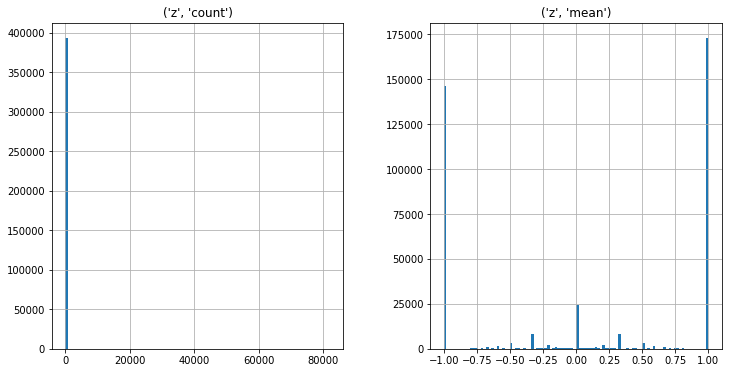

In [11]:
data.groupby([f"x_{i}" for i in range(48)])[["z"]].agg(['mean', 'count']).hist(bins=100, figsize=(12,6)) #.groupby([f"x_{i}" for i in range(48)])[["z"]].mean()